# Catchment Scale Data Analysis

## 1. Preparing the data

In [8]:
## Importing library and setting up
library(stringr)
library(ggplot2)
library(dplyr)

rm(list=ls())

In [9]:
#change this to working directory
setwd("D:/Wageningen/Period 1/EDCA/Part 2/Stew Strockhorsterdijk")

In [10]:
discharge = read.csv('Discharge.csv', skip=16, sep=";")
upstream = read.csv('Upstream.csv', skip=16, sep=";")
downstream = read.csv('Downstream.csv', skip=16, sep=";")
valve = read.csv('Valve.csv', skip=16, sep=";")

In [11]:
#rename columns
colnames(discharge)[1]="Date"
colnames(discharge)[2]="Value"

colnames(upstream)[1]="Date"
colnames(upstream)[2]="Value"

colnames(downstream)[1]="Date"
colnames(downstream)[2]="Value"

colnames(valve)[1]="Date"
colnames(valve)[2]="Value"

print(head(discharge))

                 Date Value
1 2010-08-22 15:00:00   ---
2 2010-08-22 16:00:00   ---
3 2010-08-22 17:00:00   ---
4 2010-08-22 18:00:00   ---
5 2010-08-22 19:00:00   ---
6 2010-08-22 20:00:00   ---


In [12]:
#filtering data
discharge$Value=str_trim(discharge$Value)
discharge$Value[discharge$Value == "---"] <- NA
discharge$Value = as.numeric(gsub(",", ".", gsub("\\.", "", discharge$Value)))

upstream$Value=str_trim(upstream$Value)
upstream$Value[upstream$Value == "---"] <- NA
upstream$Value = as.numeric(gsub(",", ".", gsub("\\.", "", upstream$Value)))

downstream$Value=str_trim(downstream$Value)
downstream$Value[downstream$Value == "---"] <- NA
downstream$Value = as.numeric(gsub(",", ".", gsub("\\.", "", downstream$Value)))

valve$Value=str_trim(valve$Value)
valve$Value[valve$Value == "---"] <- NA
valve$Value = as.numeric(gsub(",", ".", gsub("\\.", "", valve$Value)))

print(head(discharge))

                 Date Value
1 2010-08-22 15:00:00    NA
2 2010-08-22 16:00:00    NA
3 2010-08-22 17:00:00    NA
4 2010-08-22 18:00:00    NA
5 2010-08-22 19:00:00    NA
6 2010-08-22 20:00:00    NA


In [13]:
#changing date format to POSIXlt objects
discharge$Date <- as.POSIXlt(discharge$Date, format="%Y-%m-%d %H:%M:%S")
valve$Date <- as.POSIXlt(valve$Date, format="%Y-%m-%d %H:%M:%S")
upstream$Date <- as.POSIXlt(upstream$Date, format="%Y-%m-%d %H:%M:%S")
downstream$Date <- as.POSIXlt(downstream$Date, format="%Y-%m-%d %H:%M:%S")

In [14]:
#start and end full data
start_full <- min(discharge$Date[1],upstream$Date[1],valve$Date[1],downstream$Date[1])
end_full <- max(discharge$Date[length(discharge$Date)],upstream$Date[length(upstream$Date)],valve$Date[length(valve$Date)],downstream$Date[length(downstream$Date)])

#make full data
date_sequence <- seq(from = start_full, to = end_full, by = "hour")  
full_data <- data.frame(Date = date_sequence)

full_data <- left_join(full_data, discharge, by = "Date")
colnames(full_data)[2]="Discharge"

full_data <- left_join(full_data, downstream, by = "Date")
colnames(full_data)[3]="Downstream"

full_data <- left_join(full_data, upstream, by = "Date")
colnames(full_data)[4]="Upstream"

full_data <- left_join(full_data, valve, by = "Date")
colnames(full_data)[5]="Valve"

print(head(full_data))

summary(full_data)

                 Date Discharge Downstream Upstream Valve
1 2010-08-22 15:00:00        NA     17.035   17.654    NA
2 2010-08-22 16:00:00        NA     17.034   17.654    NA
3 2010-08-22 17:00:00        NA     17.034   17.654    NA
4 2010-08-22 18:00:00        NA     17.035   17.654    NA
5 2010-08-22 19:00:00        NA     17.035   17.655    NA
6 2010-08-22 20:00:00        NA     17.036   17.655    NA


      Date                       Discharge       Downstream       Upstream    
 Min.   :2010-08-22 15:00:00   Min.   :0.000   Min.   :16.77   Min.   :17.10  
 1st Qu.:2013-12-02 13:45:00   1st Qu.:0.001   1st Qu.:17.04   1st Qu.:17.72  
 Median :2017-03-14 13:30:00   Median :0.045   Median :17.18   Median :17.77  
 Mean   :2017-03-14 13:30:00   Mean   :0.096   Mean   :17.19   Mean   :17.72  
 3rd Qu.:2020-06-24 14:15:00   3rd Qu.:0.127   3rd Qu.:17.32   3rd Qu.:17.83  
 Max.   :2023-10-05 14:00:00   Max.   :2.089   Max.   :18.59   Max.   :18.61  
                               NA's   :24408   NA's   :23905   NA's   :23947  
     Valve      
 Min.   :17.69  
 1st Qu.:17.70  
 Median :17.73  
 Mean   :17.74  
 3rd Qu.:17.75  
 Max.   :17.96  
 NA's   :18926  

## 2. Filling the Data using Q-H relationship

Warning message:
"Removed 24226 rows containing missing values (`geom_line()`)."


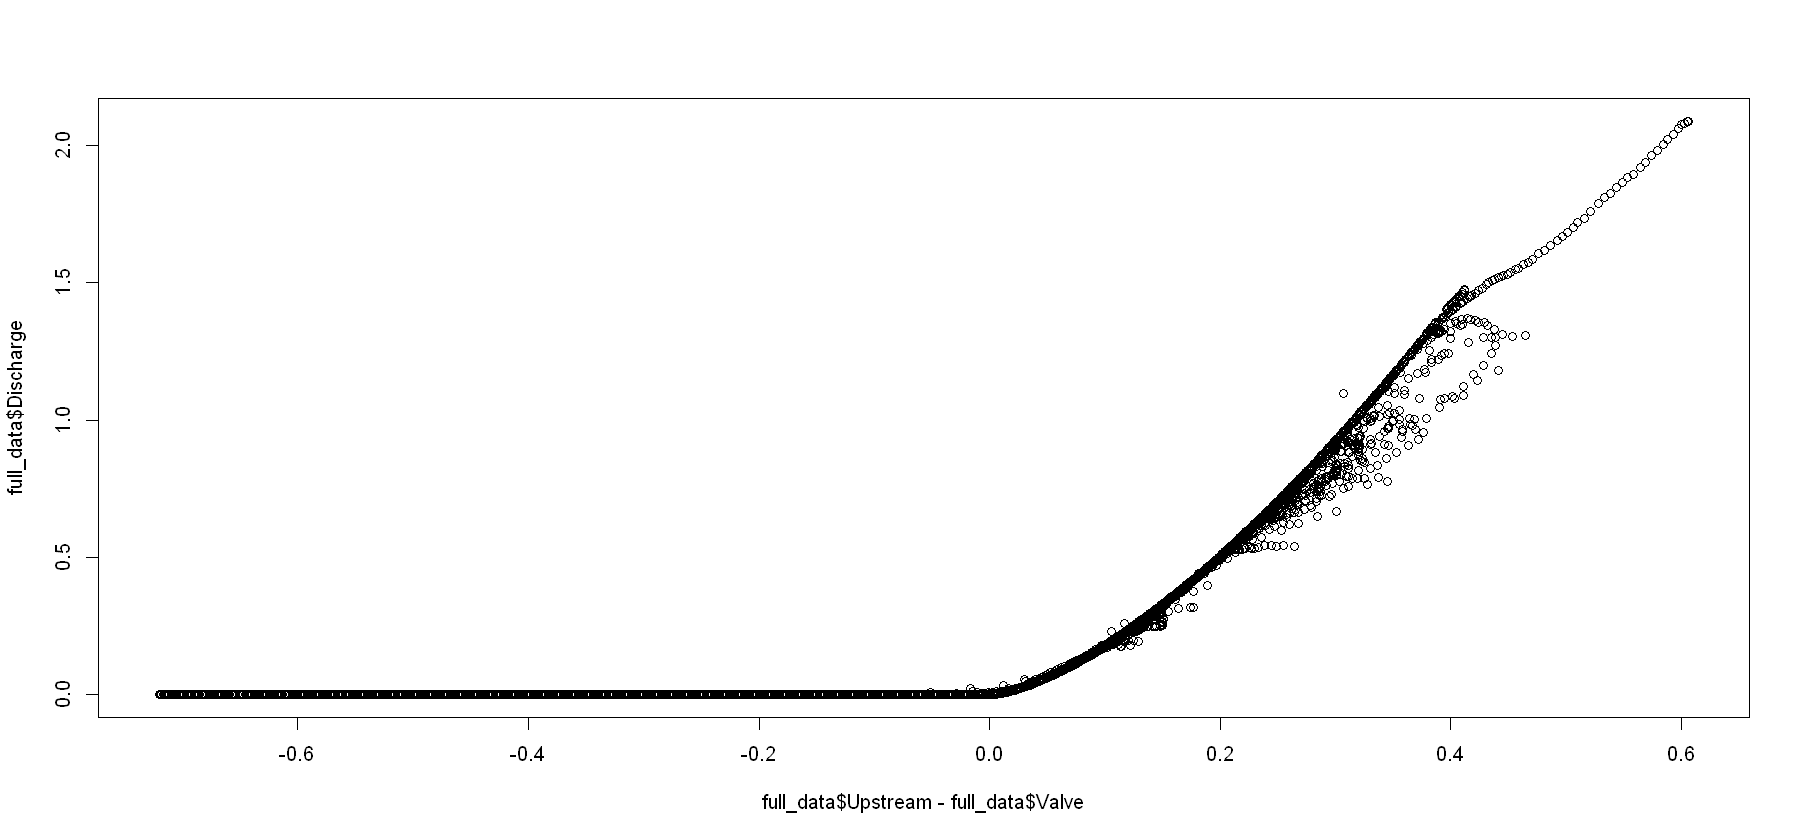

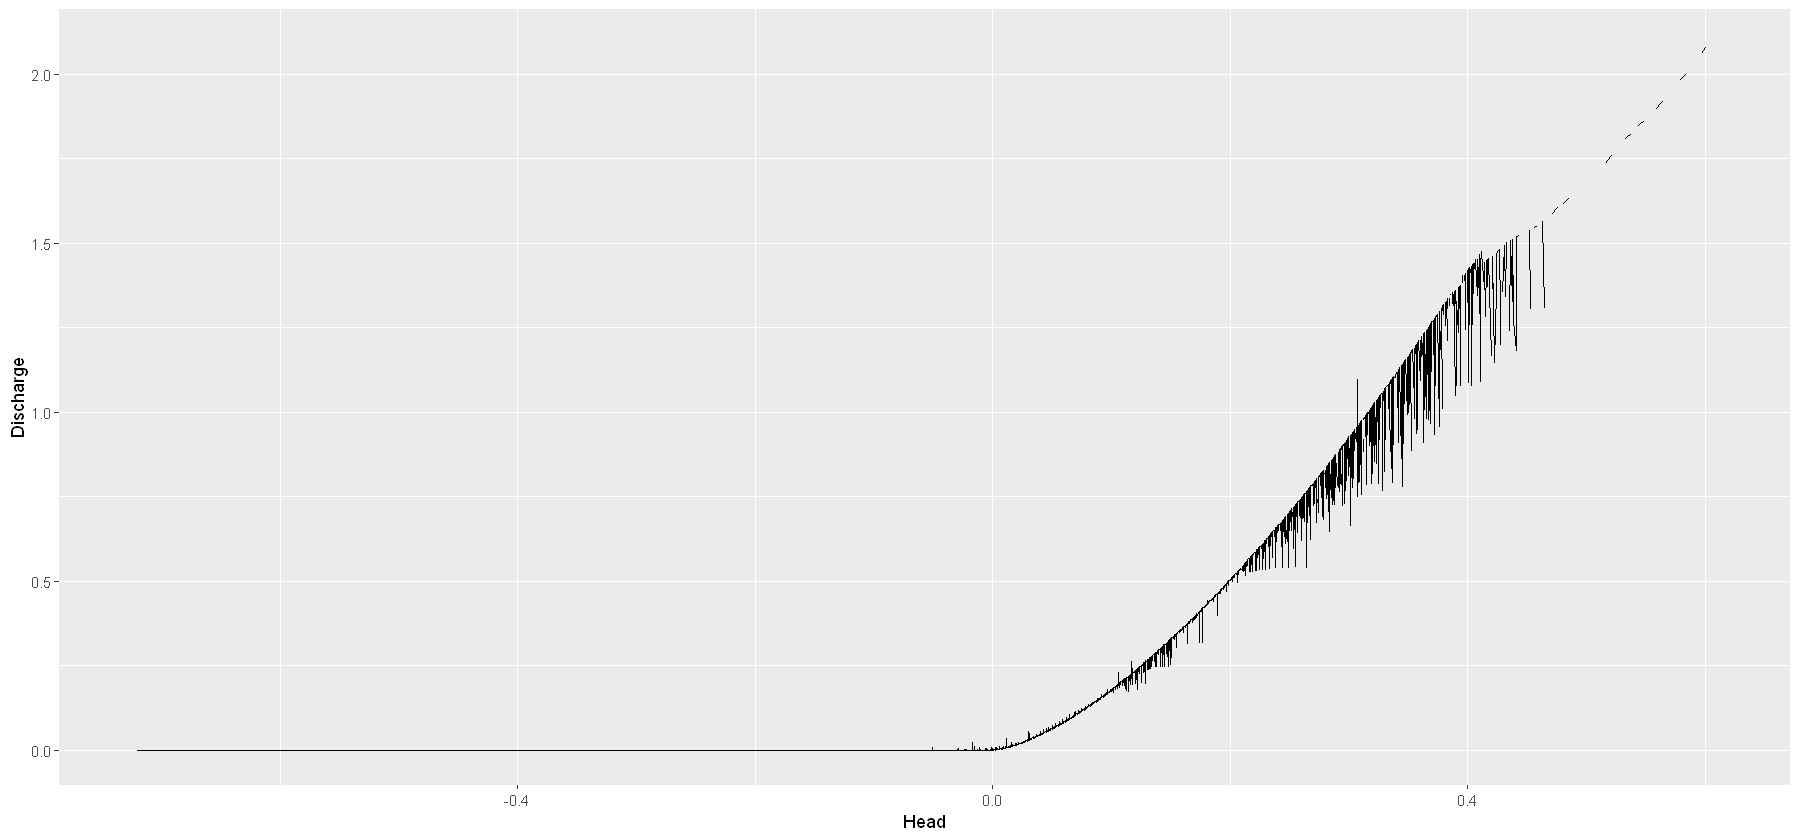

In [39]:
options(repr.plot.width = 15)

plot(x = full_data$Upstream-full_data$Valve, y = full_data$Discharge)

ggplot(full_data, aes(x = Upstream-Valve, y = Discharge)) +
  geom_line() +
  labs(y = "Discharge", x = "Head") 

In [27]:
full_data$Discharge

[1]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
   [13]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
   [25]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
   [37]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
   [49]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
   [61]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
   [73]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
   [85]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
   [97]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [109]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [121]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [133]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [145]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [157]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [169]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [181]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [193]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [205]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [217]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [229]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [241]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [253]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [265]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [277]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [289]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [301]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [313]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [325]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [337]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [349]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [361]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [373]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [385]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [397]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [409]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [421]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [433]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [445]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [457]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [469]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [481]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [493]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [505]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [517]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [529]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [541]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [553]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [565]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [577]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [589]    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA    NA
  [6

In [16]:
#start and end period
start = "2015-01-01"
end = "2018-01-01"

Warning message:
"Removed 13 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 13 rows containing missing values (`geom_line()`)."


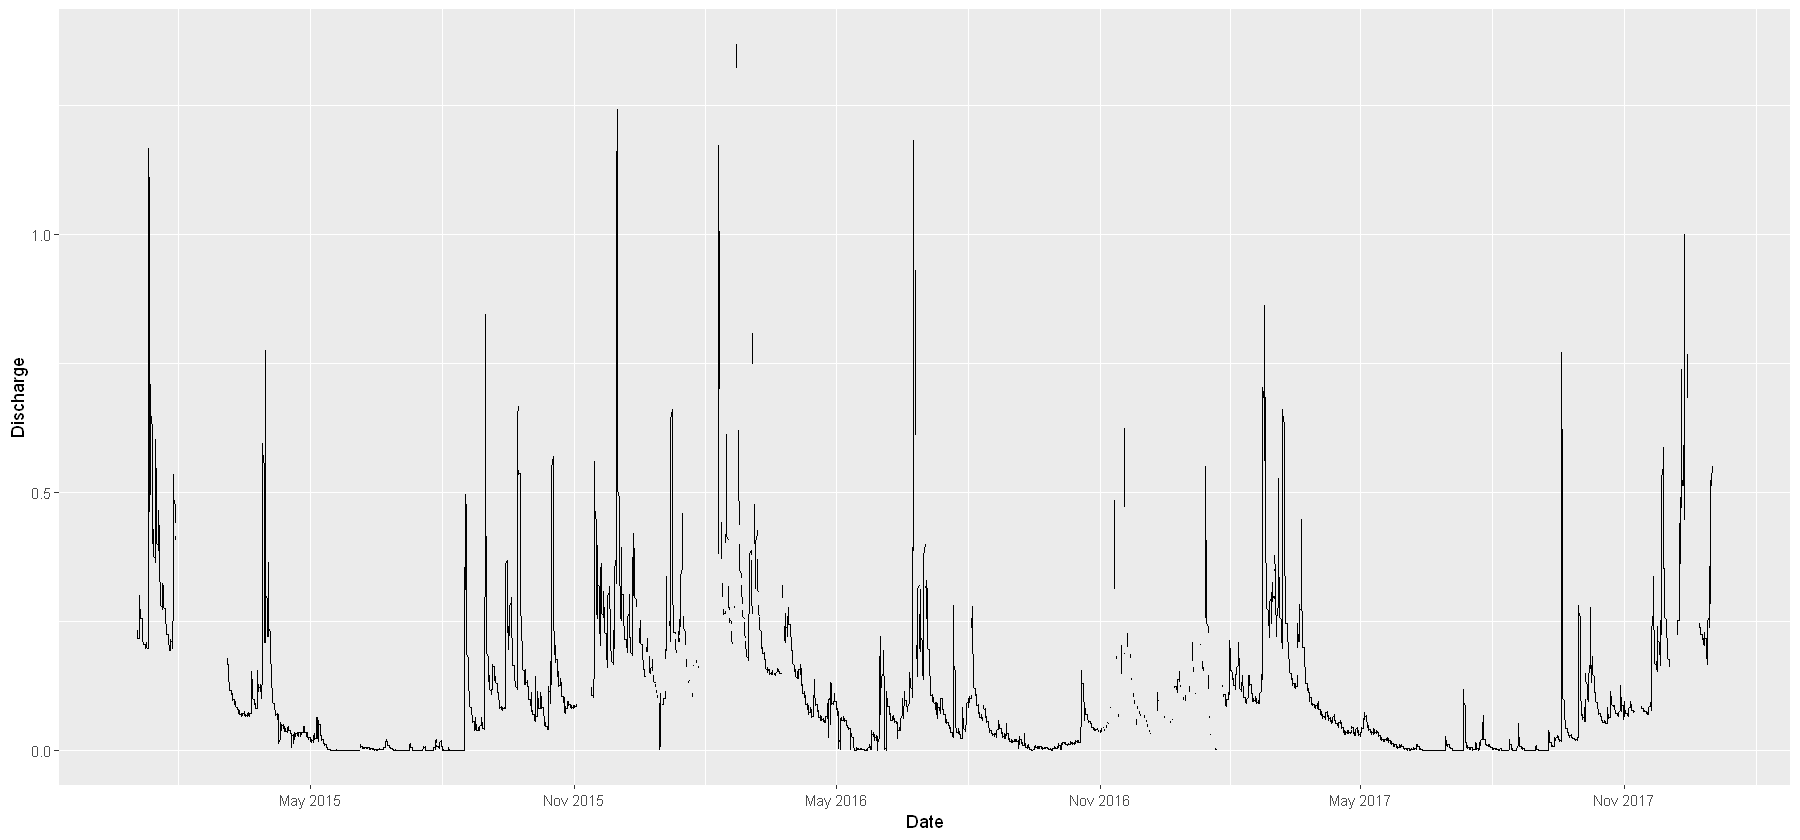

Warning message:
"Removed 13 rows containing missing values (`geom_line()`)."


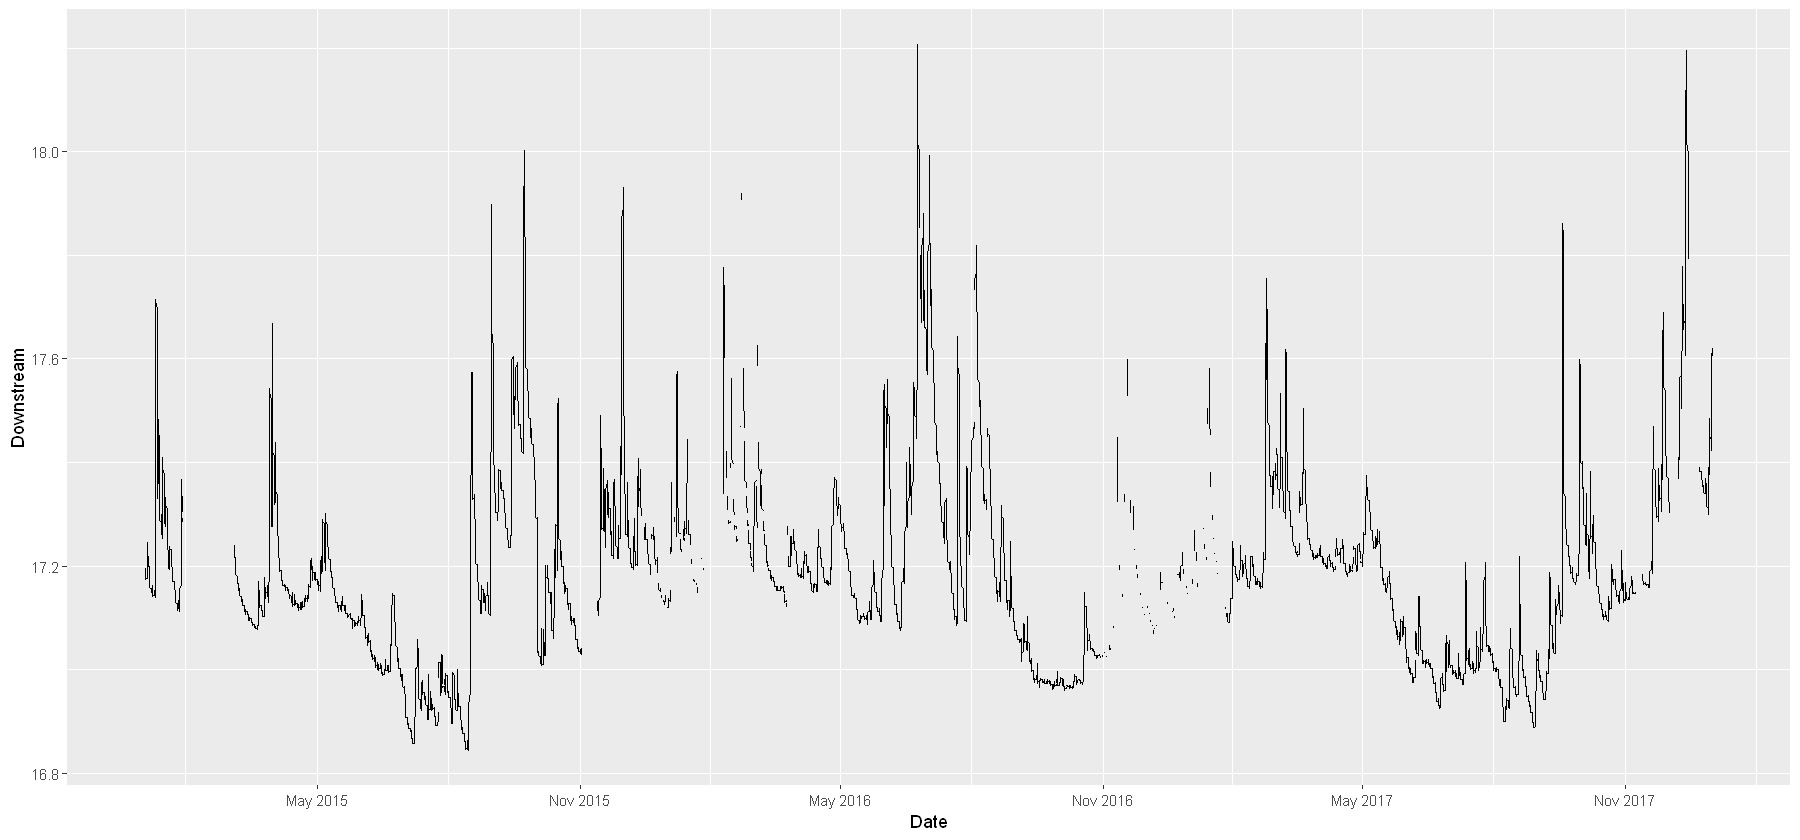

Warning message:
"Removed 12 rows containing missing values (`geom_line()`)."


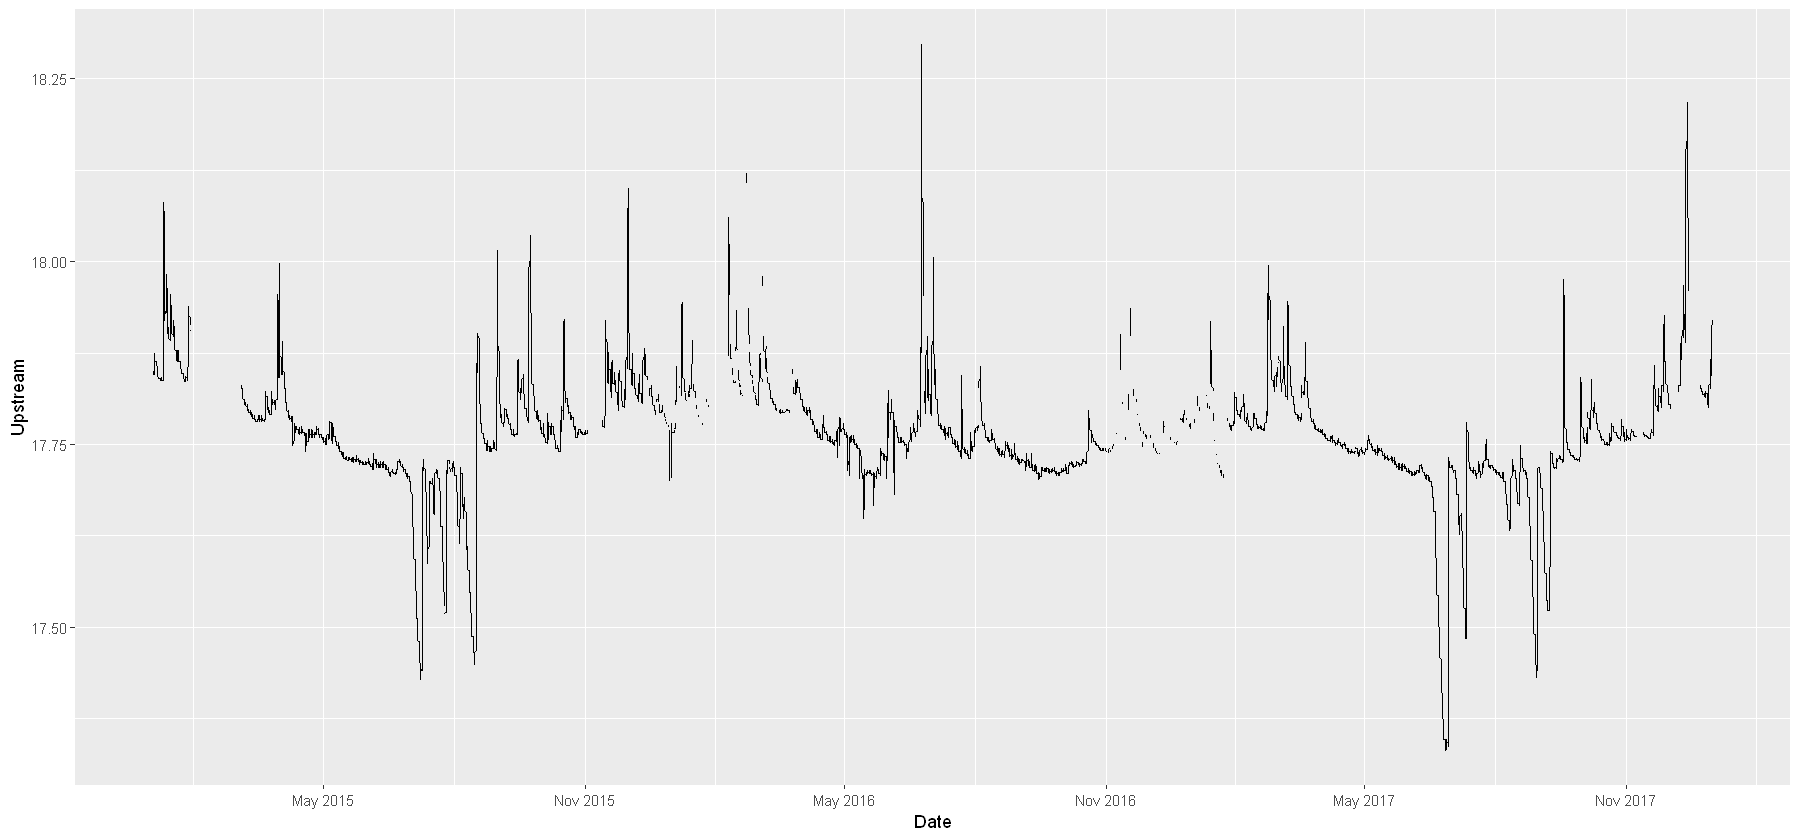

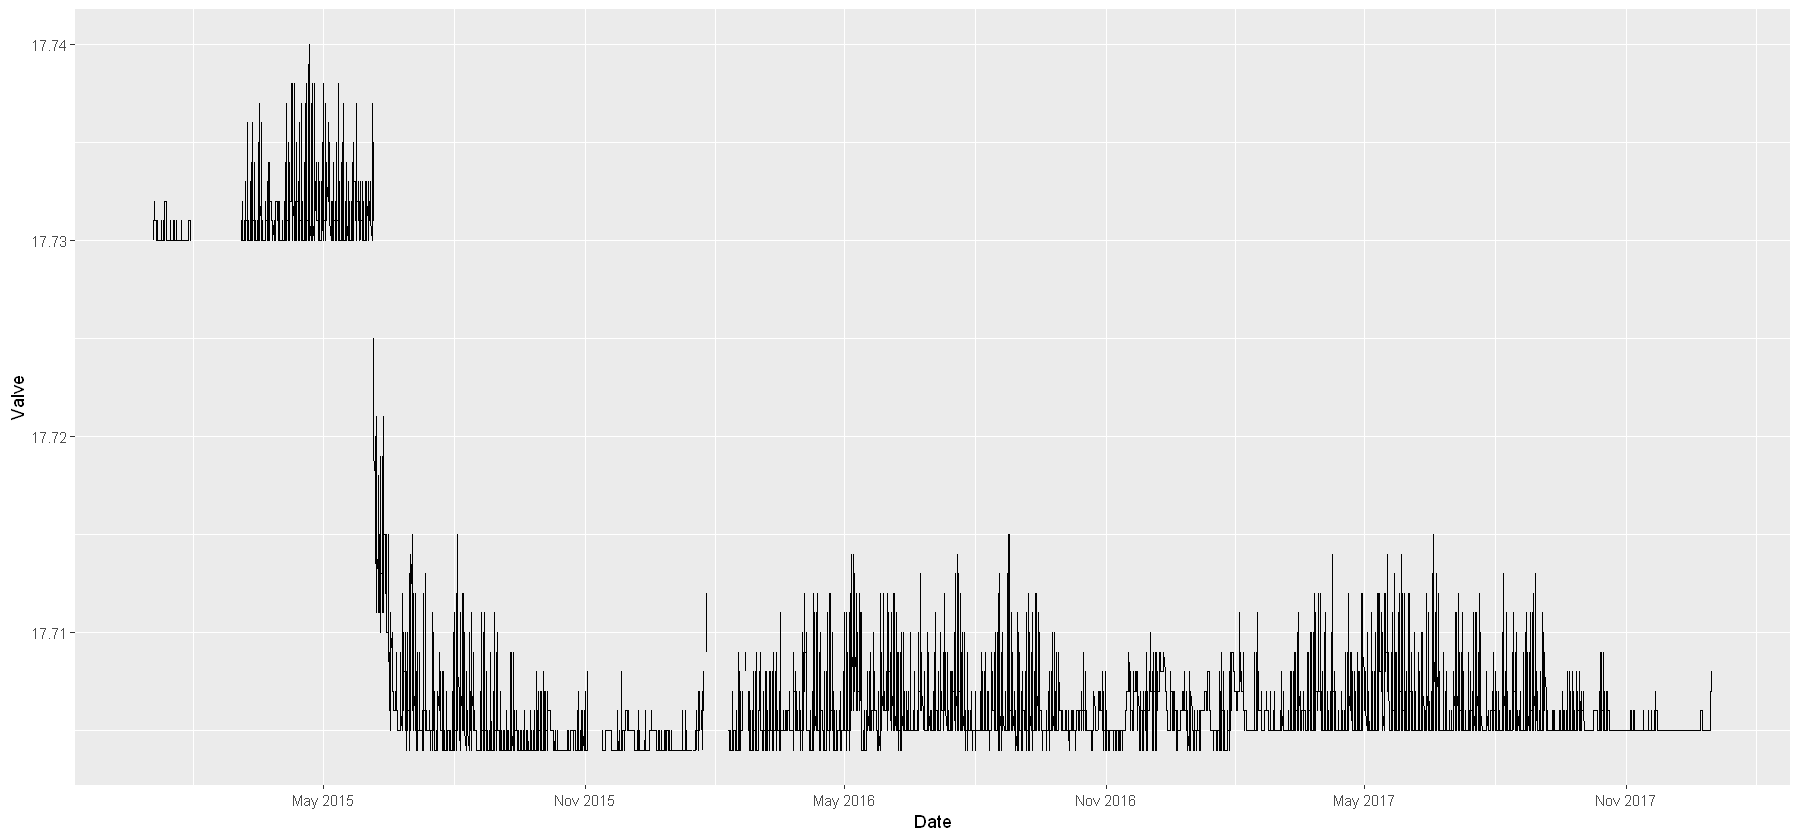

In [17]:
#plotting
options(repr.plot.width = 15)

discharge_subset <- discharge[discharge$Date >= as.POSIXlt(start) & discharge$Date <= as.POSIXlt(end), ]
downstream_subset <- downstream[downstream$Date >= as.POSIXlt(start) & downstream$Date <= as.POSIXlt(end), ]
upstream_subset <- upstream[upstream$Date >= as.POSIXlt(start) & upstream$Date <= as.POSIXlt(end), ]
valve_subset <- valve[valve$Date >= as.POSIXlt(start) & valve$Date <= as.POSIXlt(end), ]

#plotting ggplot
ggplot(discharge_subset, aes(x = as.Date(Date), y = Value)) +
  geom_line() +
  labs(y = "Discharge", x = "Date") +
  scale_x_date(date_labels = "%b %Y", date_breaks = "6 months")

ggplot(downstream_subset, aes(x = as.Date(Date), y = Value)) +
  geom_line() +
  labs(y = "Downstream", x = "Date") +
  scale_x_date(date_labels = "%b %Y", date_breaks = "6 months")

ggplot(upstream_subset, aes(x = as.Date(Date), y = Value)) +
  geom_line() +
  labs(y = "Upstream", x = "Date") +
  scale_x_date(date_labels = "%b %Y", date_breaks = "6 months")

ggplot(valve_subset, aes(x = as.Date(Date), y = Value)) +
  geom_line() +
  labs(y = "Valve", x = "Date") +
  scale_x_date(date_labels = "%b %Y", date_breaks = "6 months")


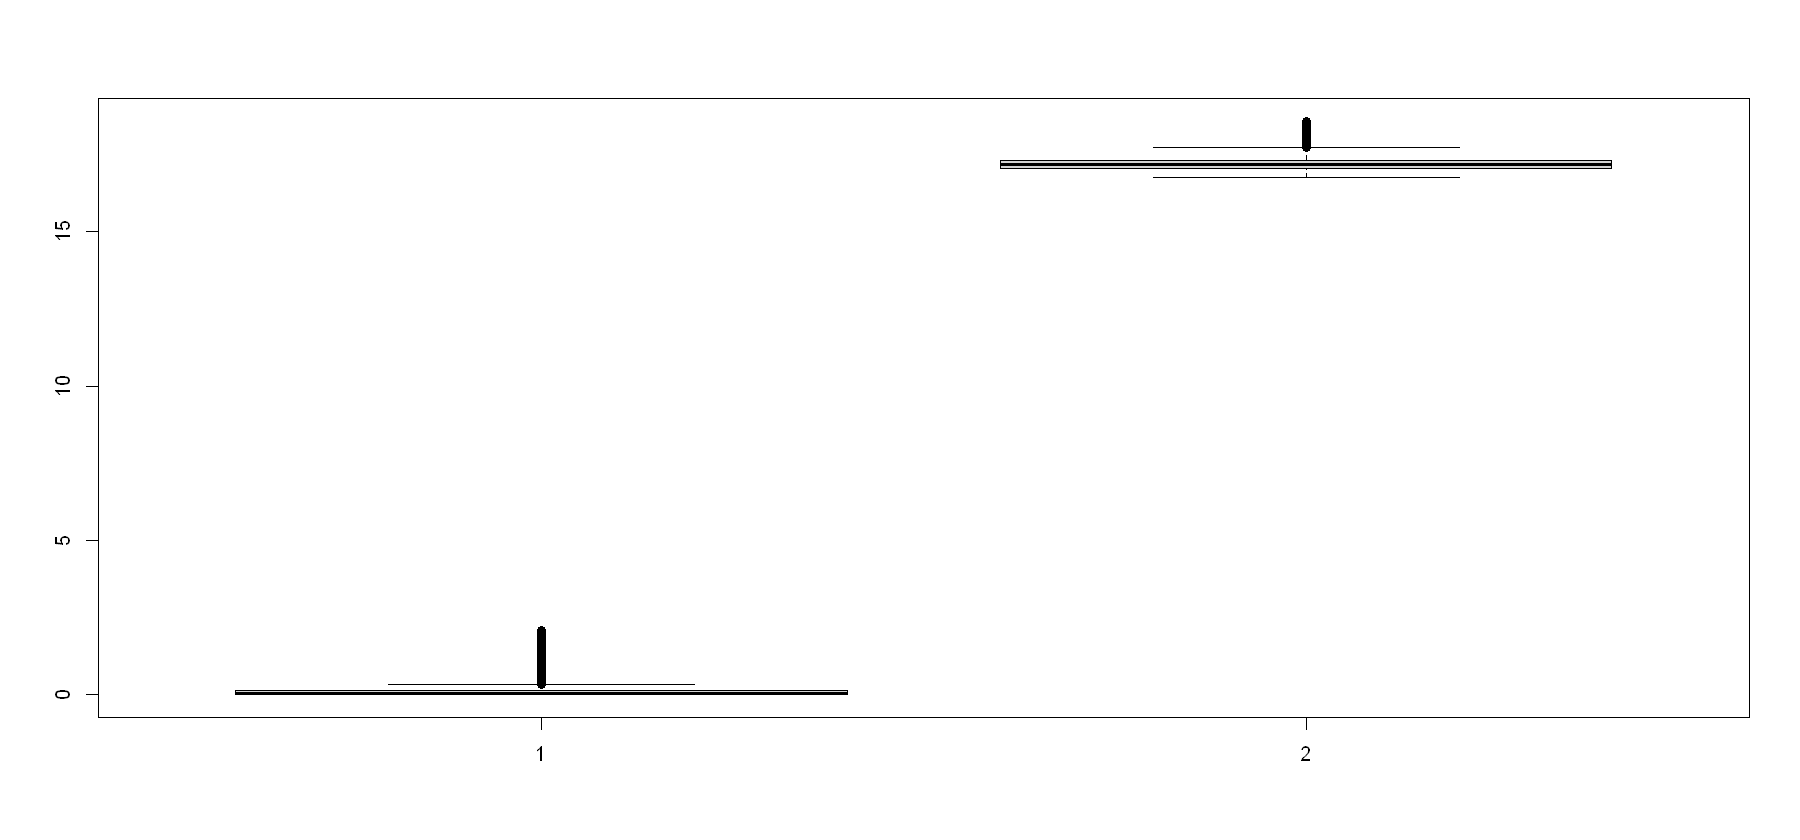

In [18]:
boxplot(full_data$Discharge,full_data$Downstream)